## 1. Imports


In [9]:
import sys
sys.path.append('../')
from visualizations import impact_bar_plots
from evaluation import *
from testing import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [10]:
data_path = '../data/results/test_1/'
folders= ['dt','gnb','lgr','gbt']
folders = ['dt']

## 2. DI_plots and CSV

[6.67, -40.3, -11.52, -17.76, -6.76, 6.67, -55.15, 6.67, -30.35, 6.67, 6.67]
[0.0, -24.82, -10.4, -22.11, -18.23, 6.89, 0.0, -15.03, -23.89, 0.0, 7.63]
[6.74, -42.25, -7.95, -19.51, -6.71, 6.82, -55.15, 6.74, -31.15, 6.74, 6.74]
[5.45, -41.44, -10.8, -17.53, -4.13, 6.65, -55.15, 5.45, -33.85, 5.45, 6.55]


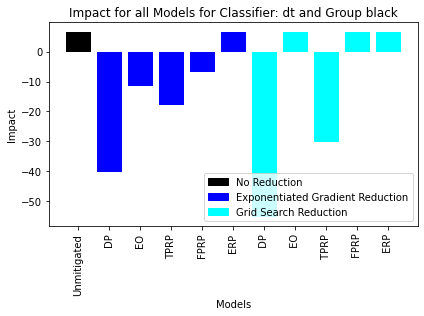

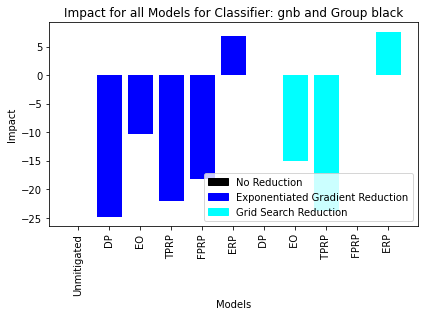

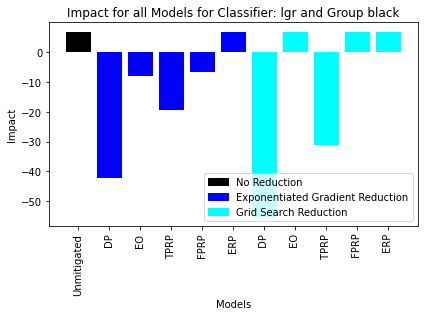

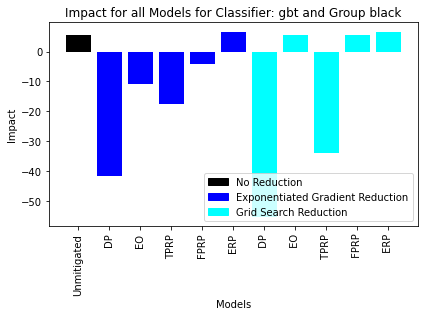

[37.98, 38.5, 36.3, 38.79, 38.55, 35.34, 39.27, 37.98, 39.27, 37.98, 37.98]
[36.13, 19.92, 34.79, 38.22, 37.47, 37.59, 36.13, 22.69, 38.48, 36.13, 29.44]
[37.84, 38.48, 35.83, 38.67, 38.35, 35.54, 39.08, 37.84, 39.08, 37.84, 37.84]
[37.98, 38.48, 36.56, 38.81, 38.79, 37.43, 39.19, 37.98, 39.08, 37.98, 37.84]


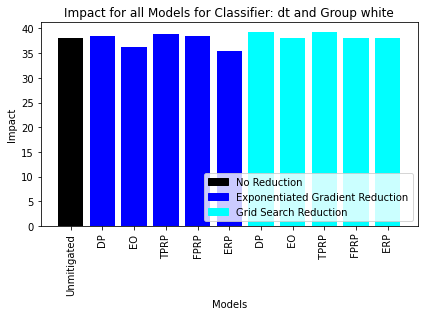

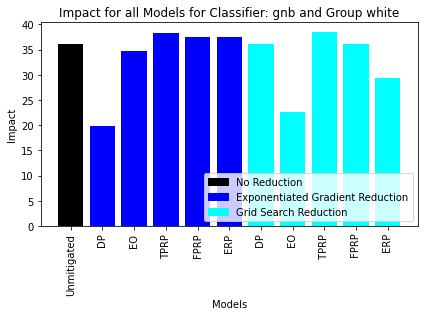

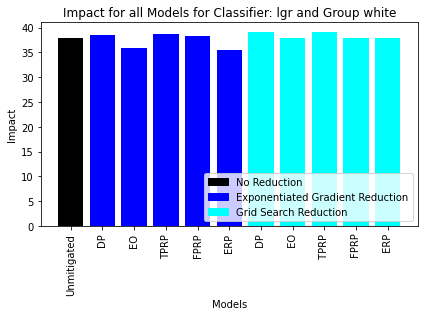

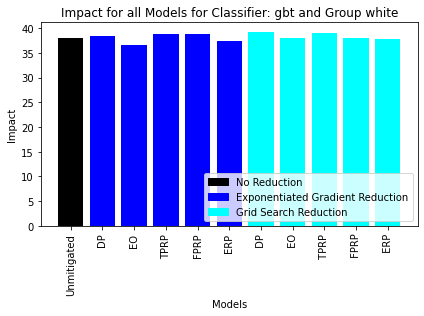

In [6]:
impact_bar_plots(data_path = '../data/results/test_5/',b_or_w = 'black',folders= ['dt','gnb','lgr','gbt'])
impact_bar_plots(data_path = '../data/results/test_5/',b_or_w = 'white',folders= ['dt','gnb','lgr','gbt'])

In [7]:
impact_csvs(data_path= '../data/results/test_4/',b_or_w = 'black', folders= ['dt','gnb','lgr','gbt'])
impact_csvs(data_path= '../data/results/test_4/',b_or_w = 'white', folders= ['dt','gnb','lgr','gbt'])

Group:  black 
 DataFrame: 
              EG+DT  EG+GNB  EG+LGR  EG+GBT  GS+DT  GS+GNB  GS+LGR  GS+GBT
Constraint                                                               
Unmitigated   6.67    0.00    6.74    5.45   6.67    0.00    6.74    5.45
DP          -40.30  -24.82  -42.25  -41.44 -55.15    0.00  -55.15  -55.15
EO          -11.52  -10.40   -7.95  -10.80   6.67  -15.03    6.74    5.45
EOO         -17.76  -22.11  -19.51  -17.53 -30.35  -23.89  -31.15  -33.85
FPER         -6.76  -18.23   -6.71   -4.13   6.67    0.00    6.74    5.45
ERP           6.67    6.89    6.82    6.65   6.67    7.63    6.74    6.55
A
B
Group:  white 
 DataFrame: 
              EG+DT  EG+GNB  EG+LGR  EG+GBT  GS+DT  GS+GNB  GS+LGR  GS+GBT
Constraint                                                               
Unmitigated  37.98   36.13   37.84   37.98  37.98   36.13   37.84   37.98
DP           38.50   19.92   38.48   38.48  39.27   36.13   39.08   39.19
EO           36.30   34.79   35.83   36.56  37.98 

C:\Users\HaRi\Documents\GitHub\delayedimpact-daadww\notebooks\..\testing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eg['Constraint'] = ['Unmitigated', 'DP', 'EO', 'EOO','FPER','ERP']
C:\Users\HaRi\Documents\GitHub\delayedimpact-daadww\notebooks\..\testing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eg['Constraint'] = ['Unmitigated', 'DP', 'EO', 'EOO','FPER','ERP']


## 3. FP/TP/TN/FN Ratios

In [8]:
types_ratios_csv(data_path = '../data/results/test_4/',folders= ['dt','lgr','gbt','gnb'])

Classifier:  dt 
 DataFrame: 
 ID        egdpB     egdpW     egeoB     egeoW    egerpB    egerpW   egfprpB  \
Value                                                                         
FN     0.007050  0.046987  0.031585  0.069630  0.093627  0.069668  0.039763   
FP     0.448957  0.066984  0.220812  0.073070  0.068528  0.079950  0.184997   
TN     0.223350  0.177705  0.451495  0.171619  0.603779  0.164739  0.487310   
TP     0.320643  0.708324  0.296108  0.685681  0.234067  0.685643  0.287930   

ID      egfprpW   egtprpB   egtprpW     gsdpB     gsdpW     gseoB     gseoW  \
Value                                                                         
FN     0.048046  0.025945  0.051901       NaN  0.076132  0.093627  0.037423   
FP     0.066153  0.265651  0.062599  0.672307  0.047252  0.068528  0.075263   
TN     0.178536  0.406655  0.182090       NaN  0.197437  0.603779  0.169426   
TP     0.707265  0.301748  0.703410  0.327693  0.679179  0.234067  0.717888   

ID       gserpB    

## 4. Score Distributions

Loading All Scores and splitting it into multiple dataframes

In [11]:
classifier_dfs = {}
dfs_b = {}
dfs_w = {}
dfs_eg = {}
dfs_gs = {}
for f in folders:
    path = f'{data_path}{f}/{f}_all_scores.csv'
    df = pd.read_csv(path)
    df = df.reset_index(drop=True)
    

    df_black = df.filter(like='B')
    df_white = df.filter(like='W')
    df_eg = pd.concat([df.iloc[:,:4],df.filter(like='eg')],axis=1)
    df_gs = pd.concat([df.iloc[:,:4],df.filter(like='gs')],axis=1)
    
    classifier_dfs[f] = df
    dfs_b[f] = df_black
    dfs_w[f] = df_white
    dfs_eg[f] = df_eg
    dfs_gs[f] = df_gs

Checking if normal distributions:

In [12]:
for c,df in classifier_dfs.items():
    for col in df:
        print(col)
        data=df[col].dropna(axis=0)
        print(stats.kstest(data, "norm"))

testB
KstestResult(statistic=1.0, pvalue=0.0)
testW
KstestResult(statistic=1.0, pvalue=0.0)
unmitB
KstestResult(statistic=1.0, pvalue=0.0)
unmitW
KstestResult(statistic=1.0, pvalue=0.0)
egdpB
KstestResult(statistic=1.0, pvalue=0.0)
egdpW
KstestResult(statistic=1.0, pvalue=0.0)
egeoB
KstestResult(statistic=1.0, pvalue=0.0)
egeoW
KstestResult(statistic=1.0, pvalue=0.0)
egtprpB
KstestResult(statistic=1.0, pvalue=0.0)
egtprpW
KstestResult(statistic=1.0, pvalue=0.0)
egfprpB
KstestResult(statistic=1.0, pvalue=0.0)
egfprpW
KstestResult(statistic=1.0, pvalue=0.0)
egerpB
KstestResult(statistic=1.0, pvalue=0.0)
egerpW
KstestResult(statistic=1.0, pvalue=0.0)
gsdpB
KstestResult(statistic=1.0, pvalue=0.0)
gsdpW
KstestResult(statistic=1.0, pvalue=0.0)
gseoB
KstestResult(statistic=1.0, pvalue=0.0)
gseoW
KstestResult(statistic=1.0, pvalue=0.0)
gstprpB
KstestResult(statistic=1.0, pvalue=0.0)
gstprpW
KstestResult(statistic=1.0, pvalue=0.0)
gsfprpB
KstestResult(statistic=1.0, pvalue=0.0)
gsfprpW
KstestRe

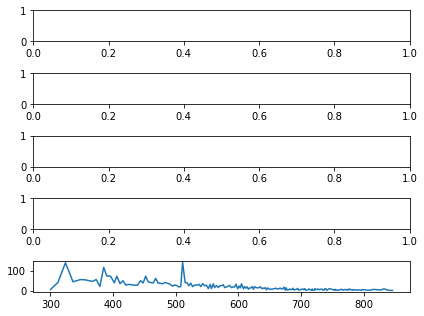

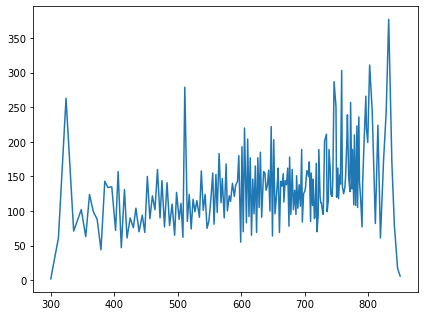

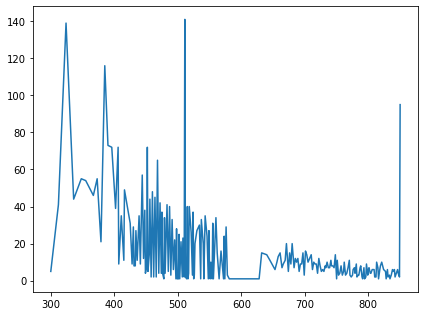

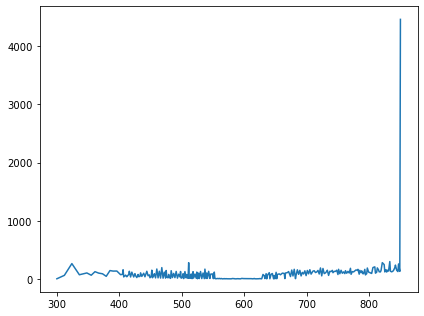

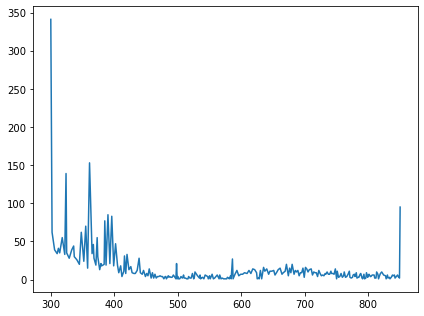

In [13]:


for c,df in classifier_dfs.items():
    fig,axes = plt.subplots(nrows= 5)
    
    for i in range(5):
        axes[i] = plt.plot(df.iloc[:,i].value_counts().sort_index())
        plt.tight_layout()
        plt.show()
        